Hello everyone!! I am still working on the notebook. Thanks for taking a look at my notebook. Upvote it if you find it useful or if you like it.

## Importing the libraries and the dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-mar-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2022/train.csv
/kaggle/input/tabular-playground-series-mar-2022/test.csv


In [2]:
# importing scikit-learn libraries
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# importing additional libraries
from datetime import datetime
import calendar

In [3]:
df = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

## Data analysis and extraction

In [4]:
df

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


In [5]:
test

,row_id,time,x,y,direction
0,848835,1991-09-30 12:00:00,0,0,EB
1,848836,1991-09-30 12:00:00,0,0,NB
2,848837,1991-09-30 12:00:00,0,0,SB
3,848838,1991-09-30 12:00:00,0,1,EB
4,848839,1991-09-30 12:00:00,0,1,NB
...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB
2336,851171,1991-09-30 23:40:00,2,3,NE
2337,851172,1991-09-30 23:40:00,2,3,SB
2338,851173,1991-09-30 23:40:00,2,3,SW


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   row_id      848835 non-null  int64 
 1   time        848835 non-null  object
 2   x           848835 non-null  int64 
 3   y           848835 non-null  int64 
 4   direction   848835 non-null  object
 5   congestion  848835 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 38.9+ MB


In [7]:
# set row_id as the index column
df.set_index('row_id',inplace=True)
test.set_index('row_id',inplace=True)

In [8]:
df['time'].iloc[0]

'1991-04-01 00:00:00'

In [9]:
# let's get the date for each instance and from that we can get the year, month, weekend or weekday,etc
def get_date(x):
    return x.split()[0]
df['date'] = df['time'].apply(get_date)
test['date'] = test['time'].apply(get_date)

def get_yr(x):
    return int(x.split('-')[0])

def get_month(x):
    return int(x.split('-')[1])

def get_date(x):
    return int(x.split('-')[2])

# applying the above functions
df['year'] = df['date'].apply(get_yr)
df['month'] = df['date'].apply(get_month)
df['date'] = df['date'].apply(get_date)
test['year'] = test['date'].apply(get_yr)
test['month'] = test['date'].apply(get_month)
test['date'] = test['date'].apply(get_date)

In [10]:
# now let's work on the time column by getting the hour and minute features
def reduce_time(x):
    return x.split()[1] # get's the time value alone

df['time'] = df['time'].apply(reduce_time)
test['time'] = test['time'].apply(reduce_time)

#hour
def get_hour(x):
    return int(x.split(':')[0])

#minute
def get_minute(x):
    return int(x.split(':')[1])

df['hour'] = df['time'].apply(get_hour)
df['minute'] = df['time'].apply(get_minute)

test['hour'] = test['time'].apply(get_hour)
test['minute'] = test['time'].apply(get_minute)

In [11]:
df

,time,x,y,direction,congestion,date,year,month,hour,minute
row_id,,,,,,,,,,
0,00:00:00,0,0,EB,70,1,1991,4,0,0
1,00:00:00,0,0,NB,49,1,1991,4,0,0
2,00:00:00,0,0,SB,24,1,1991,4,0,0
3,00:00:00,0,1,EB,18,1,1991,4,0,0
4,00:00:00,0,1,NB,60,1,1991,4,0,0
...,...,...,...,...,...,...,...,...,...,...
848830,11:40:00,2,3,NB,54,30,1991,9,11,40
848831,11:40:00,2,3,NE,28,30,1991,9,11,40
848832,11:40:00,2,3,SB,68,30,1991,9,11,40


In [12]:
# we have got sufficient info from the time column. Let's drop it.
df.drop('time',axis=1,inplace=True)
test.drop('time',axis=1,inplace=True)

In [13]:
df

,x,y,direction,congestion,date,year,month,hour,minute
row_id,,,,,,,,,
0,0,0,EB,70,1,1991,4,0,0
1,0,0,NB,49,1,1991,4,0,0
2,0,0,SB,24,1,1991,4,0,0
3,0,1,EB,18,1,1991,4,0,0
4,0,1,NB,60,1,1991,4,0,0
...,...,...,...,...,...,...,...,...,...
848830,2,3,NB,54,30,1991,9,11,40
848831,2,3,NE,28,30,1991,9,11,40
848832,2,3,SB,68,30,1991,9,11,40


In [14]:
# let's get the weekend or weekday feature
def weekend_or_weekday(year,month,date):
    """
    This function returns 1 if its a weekday and returns a 0 if its a weekend.
    This is done to encode the feature at this stage itself.
    """
    d = datetime(year,month,date)
    if d.weekday()>4:
        return 0
    else:
        return 1

df['weekday'] = df.apply(lambda x:weekend_or_weekday(x['year'],x['month'],x['date']),axis=1)
test['weekday'] = test.apply(lambda x:weekend_or_weekday(x['year'],x['month'],x['date']),axis=1)

In [15]:
# let's get the day detail
def get_day(year,month,date):
    day = datetime(year,month,date).weekday()
    return (calendar.day_name[day])

df['day'] = df.apply(lambda x:get_day(x['year'],x['month'],x['date']),axis=1)
test['day'] = test.apply(lambda x:get_day(x['year'],x['month'],x['date']),axis=1)

In [16]:
# am or pm
def am_or_pm(x):
    if x>=12:
        return 1
    else:
        return 0

df['PM'] = df['hour'].apply(am_or_pm)
test['PM'] = test['hour'].apply(am_or_pm)

In [17]:
df

,x,y,direction,congestion,date,year,month,hour,minute,weekday,day,PM
row_id,,,,,,,,,,,,
0,0,0,EB,70,1,1991,4,0,0,1,Monday,0
1,0,0,NB,49,1,1991,4,0,0,1,Monday,0
2,0,0,SB,24,1,1991,4,0,0,1,Monday,0
3,0,1,EB,18,1,1991,4,0,0,1,Monday,0
4,0,1,NB,60,1,1991,4,0,0,1,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
848830,2,3,NB,54,30,1991,9,11,40,1,Monday,0
848831,2,3,NE,28,30,1991,9,11,40,1,Monday,0
848832,2,3,SB,68,30,1991,9,11,40,1,Monday,0


## Data visualization and inferences

In [18]:
df['month'].unique()

array([4, 5, 6, 7, 8, 9])

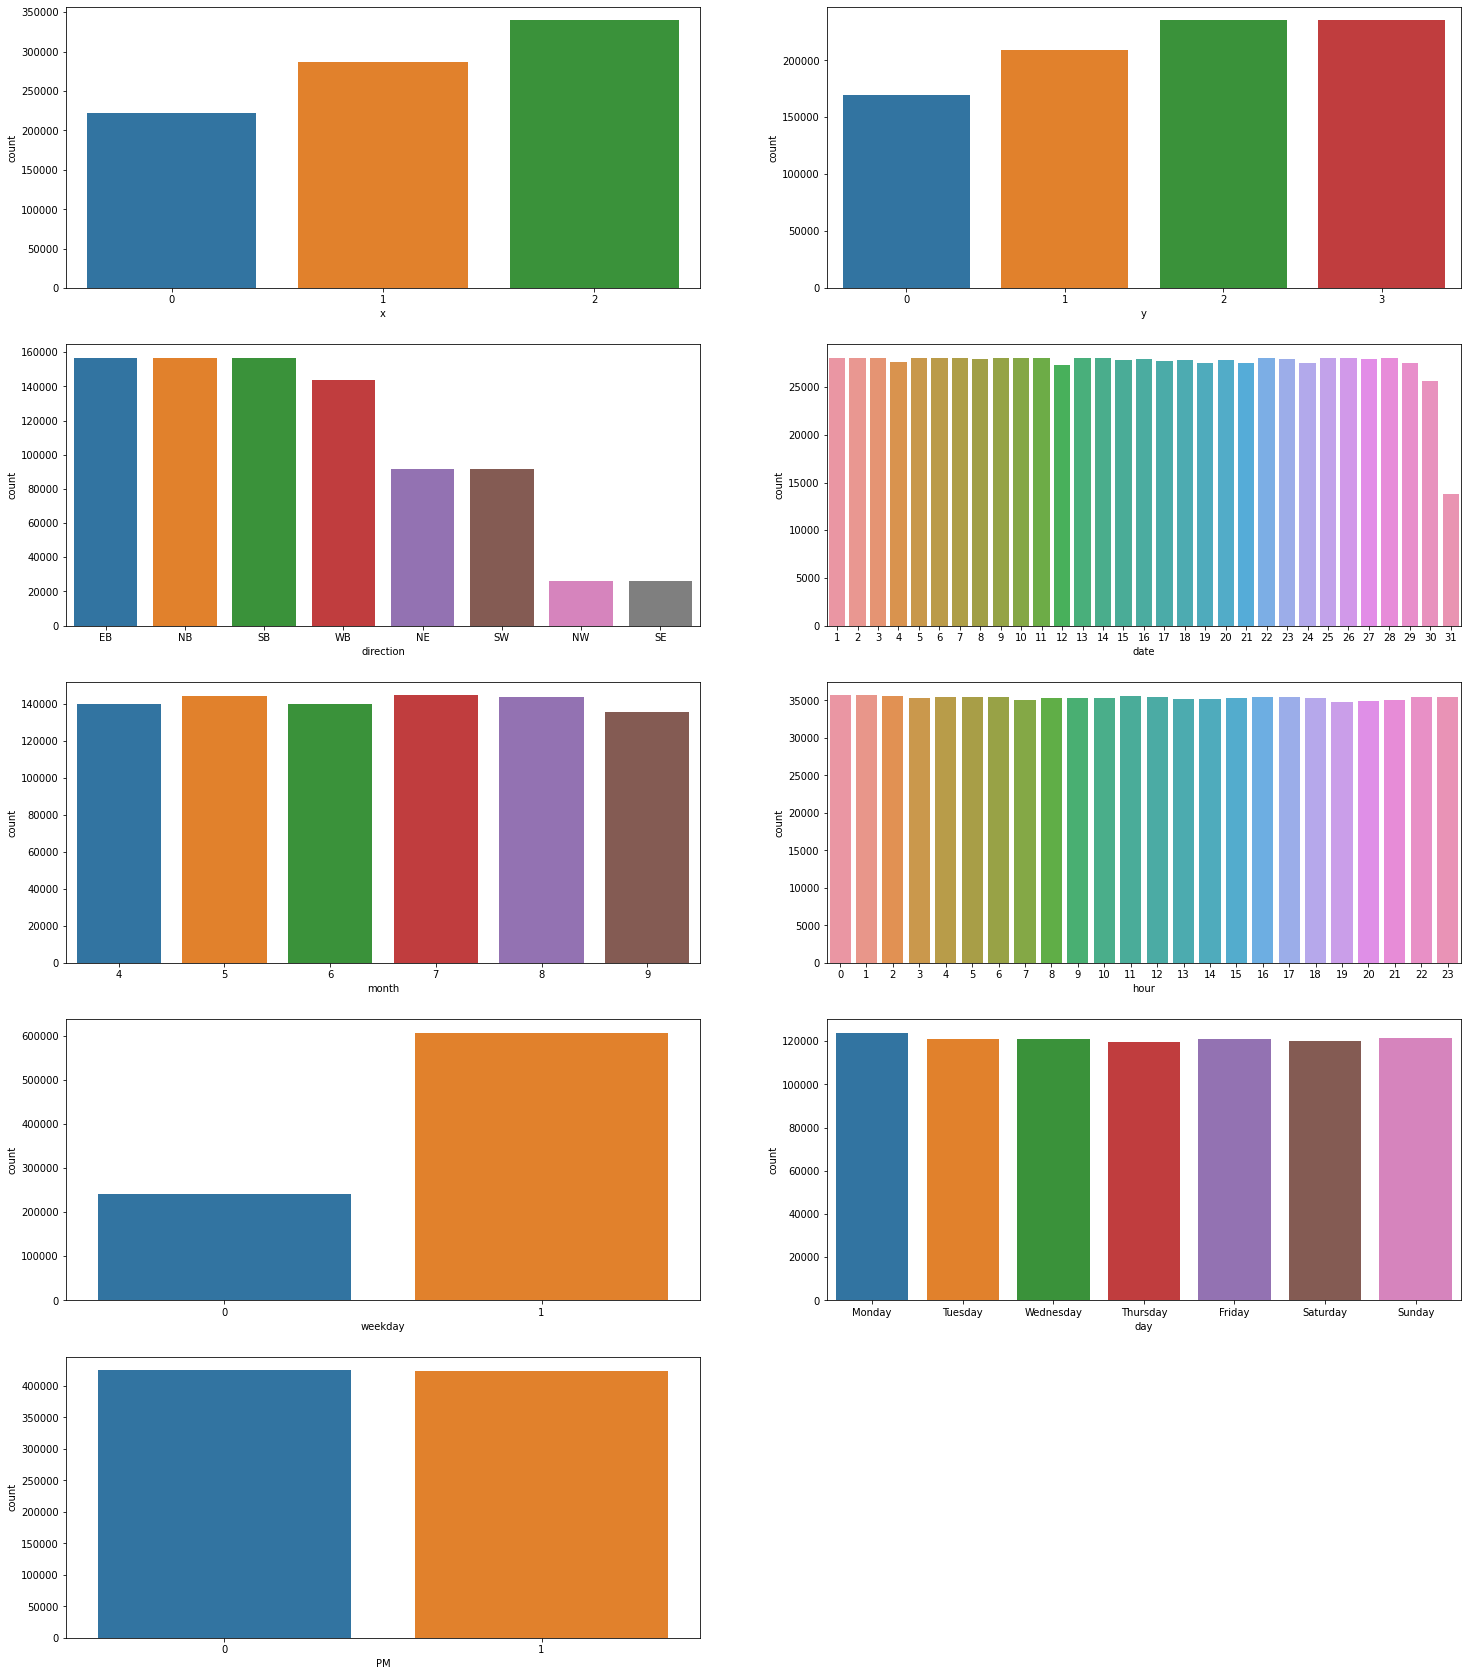

In [19]:
cnts = list(df.drop(['congestion','year','minute',],axis=1).columns)

k=0
fig,ax_arr = plt.subplots(nrows=5,ncols=2,figsize=(25,30))
for i in range(5):
    for j in range(2):
        if i==4 and j==1:
            ax_arr[i][j].axis("off")
            break
        sns.countplot(x=cnts[k],data=df,ax=ax_arr[i][j])
        ax_arr[i][j].set_xlabel(cnts[k])
        k+=1

**Inferences**:
* Higher valued co-ordinates are present more in the dataset.
* NW and SE are the least travelled directions.

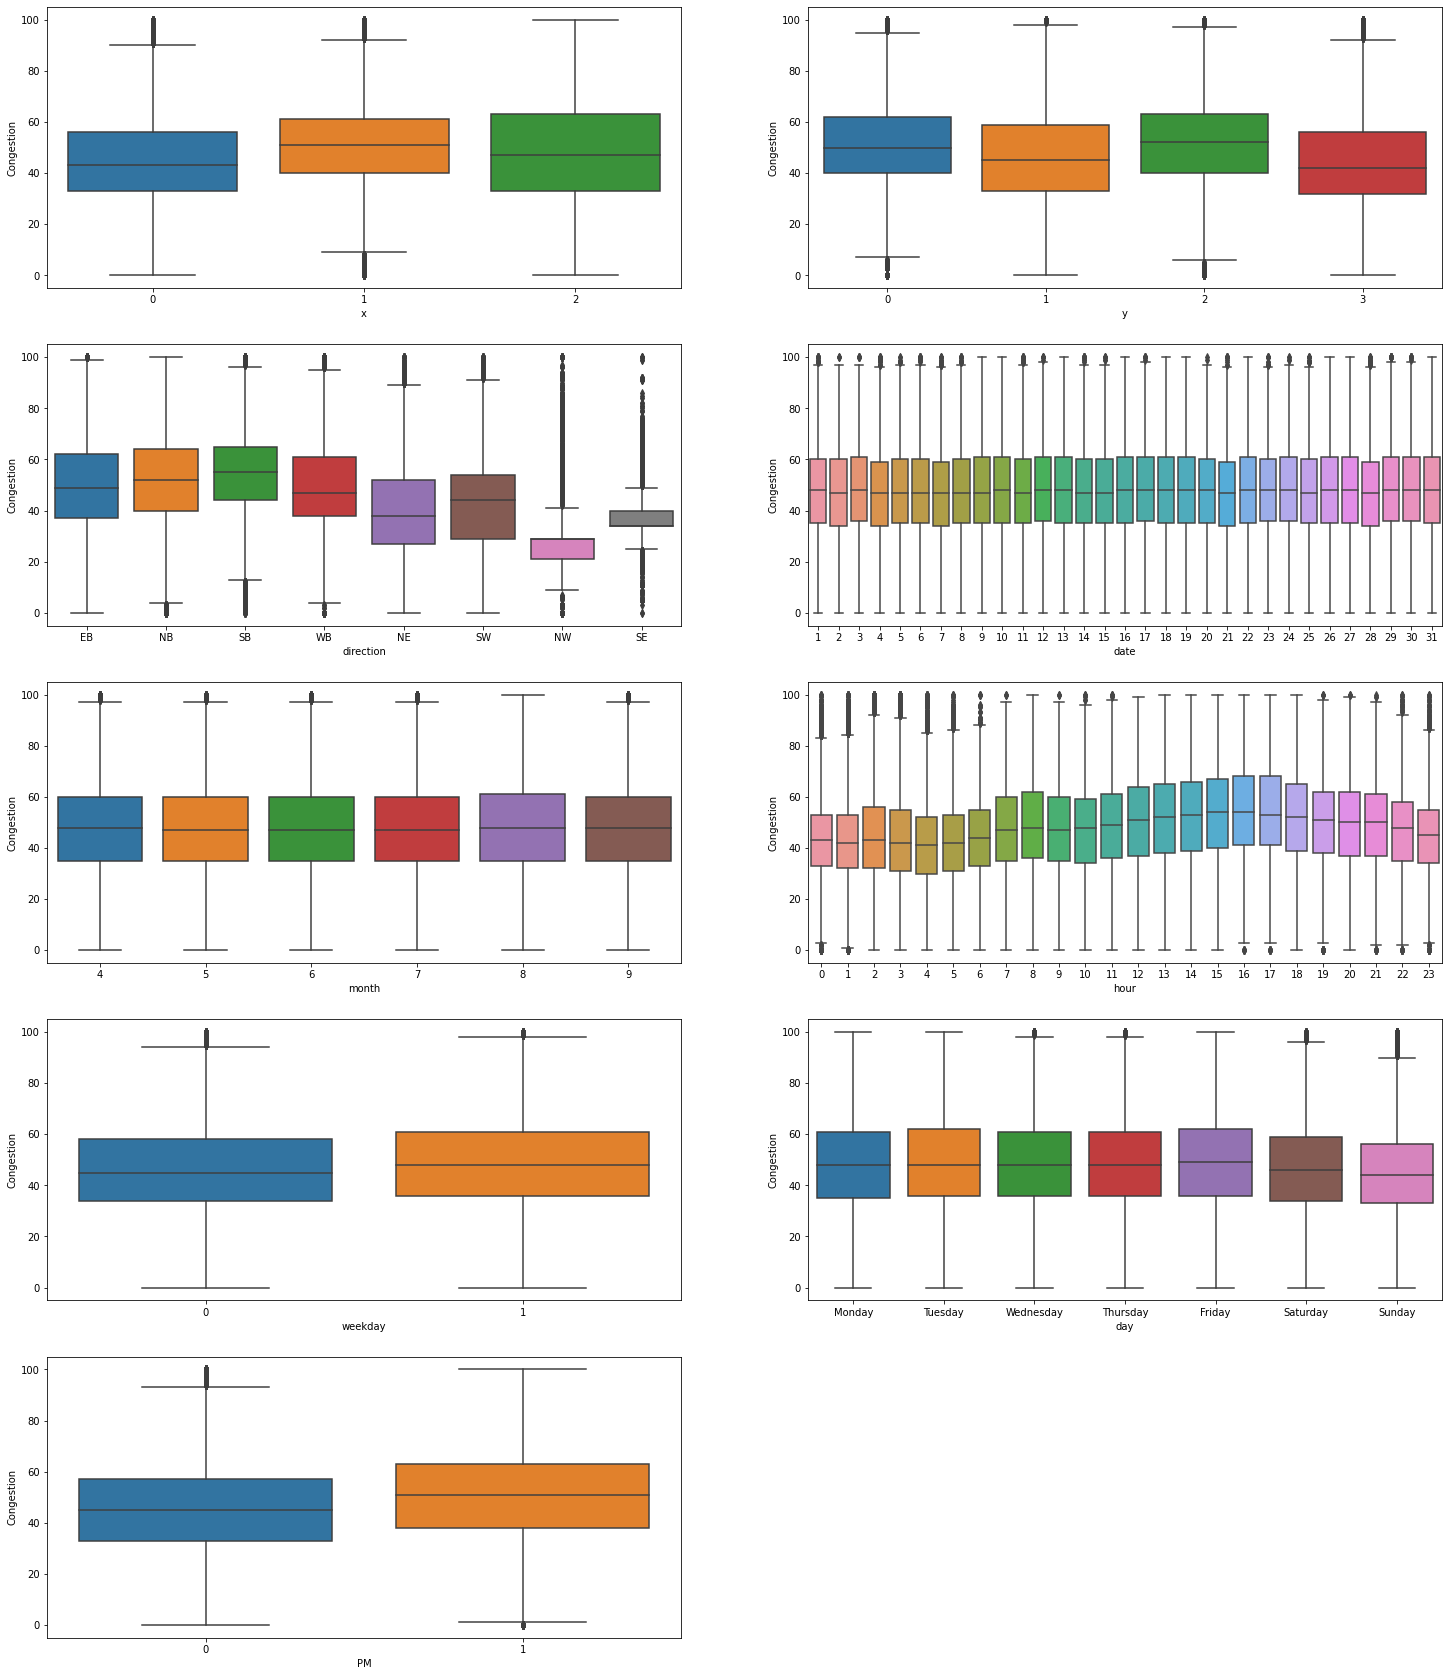

In [20]:
cnts = list(df.drop(['congestion','year','minute',],axis=1).columns)

k=0
fig,ax_arr = plt.subplots(nrows=5,ncols=2,figsize=(25,30))
for i in range(5):
    for j in range(2):
        if i==4 and j==1:
            ax_arr[i][j].axis("off")
            break
        sns.boxplot(x=cnts[k],y='congestion',data=df,ax=ax_arr[i][j])
        ax_arr[i][j].set_xlabel(cnts[k])
        ax_arr[i][j].set_ylabel('Congestion')
        k+=1

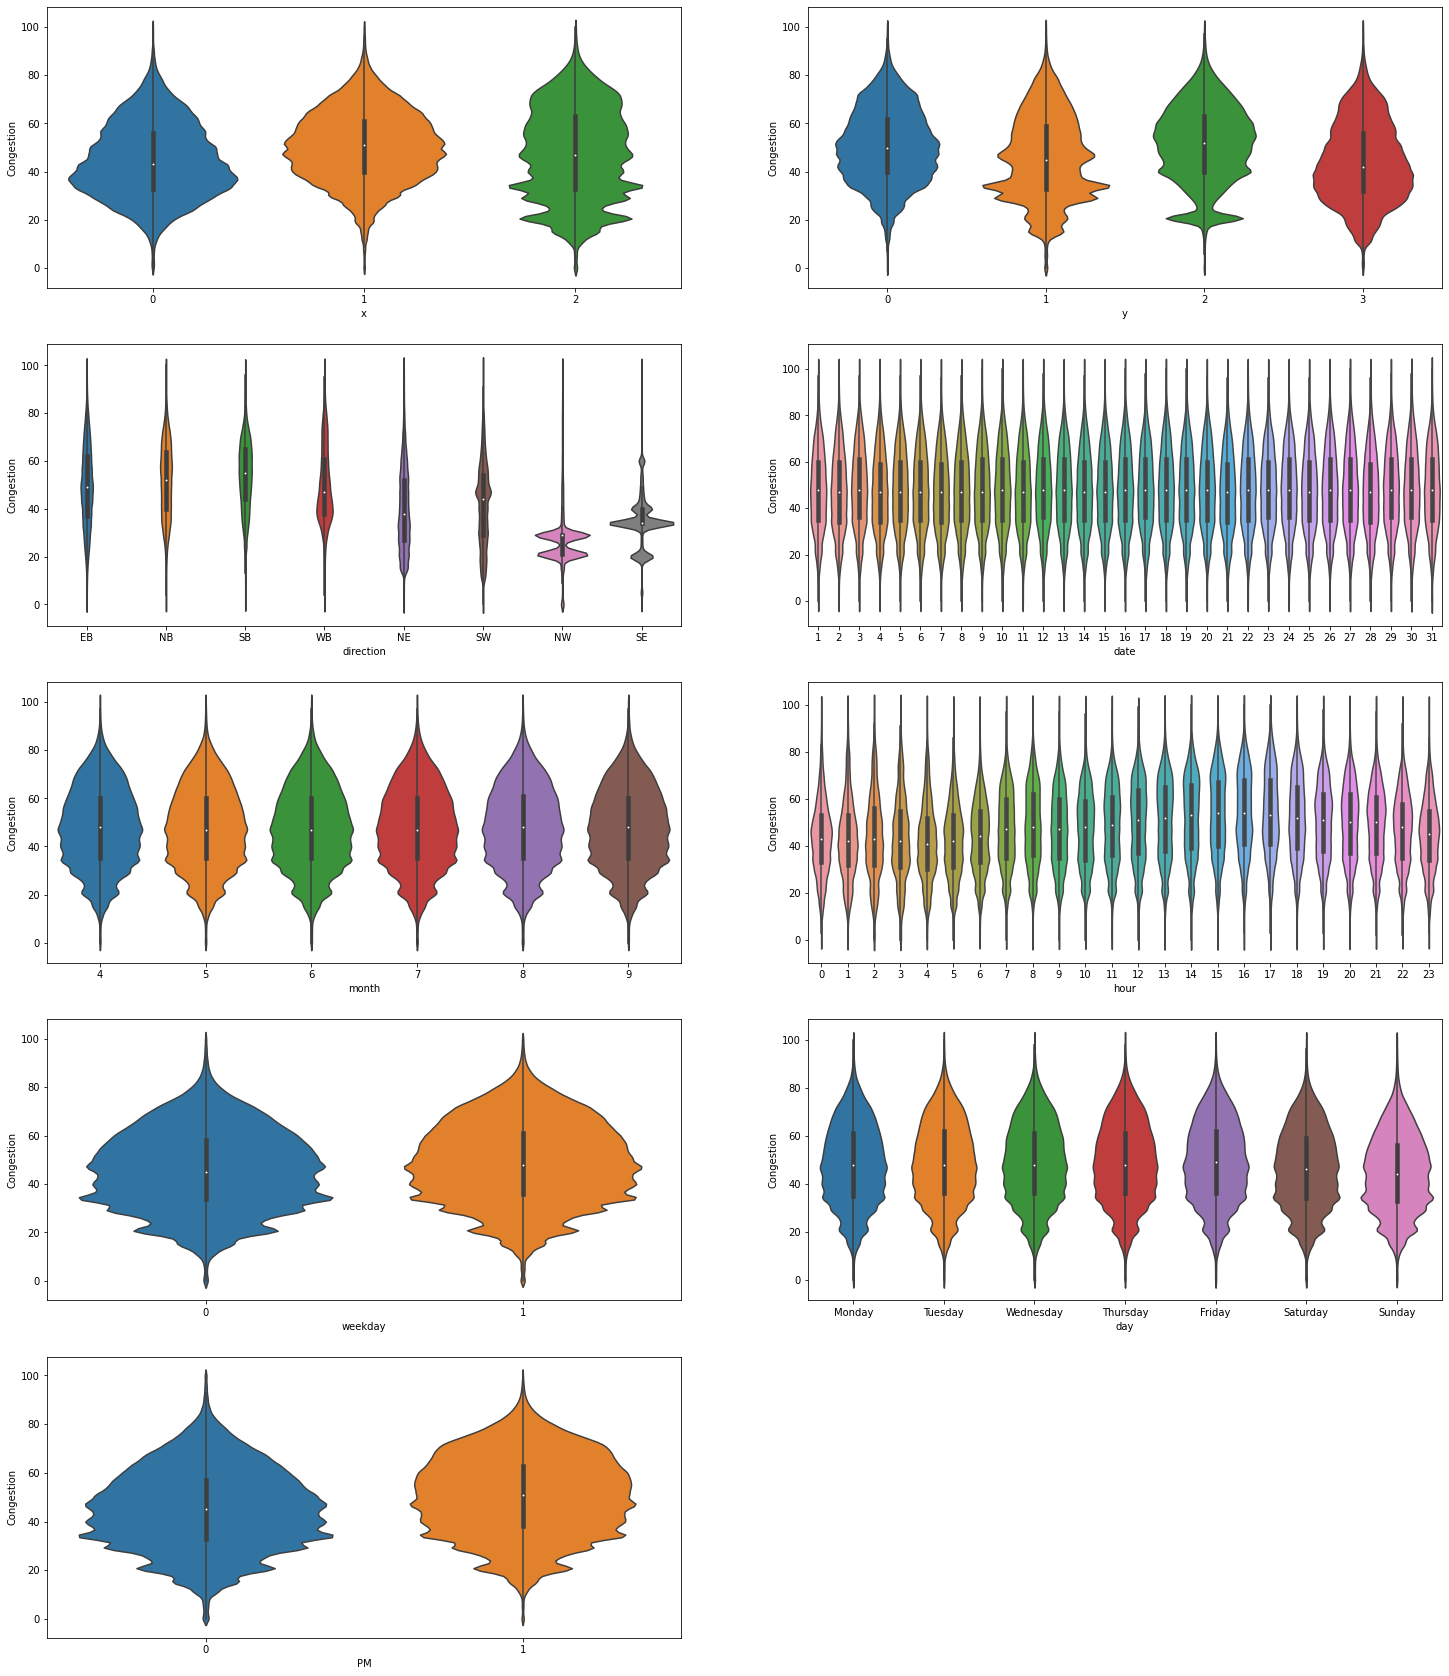

In [21]:
cnts = list(df.drop(['congestion','year','minute',],axis=1).columns)

k=0
fig,ax_arr = plt.subplots(nrows=5,ncols=2,figsize=(25,30))
for i in range(5):
    for j in range(2):
        if i==4 and j==1:
            ax_arr[i][j].axis("off")
            break
        sns.violinplot(x=cnts[k],y='congestion',data=df,ax=ax_arr[i][j])
        ax_arr[i][j].set_xlabel(cnts[k])
        ax_arr[i][j].set_ylabel('Congestion')
        k+=1

From the above violinplot we can infer that the data has not been distributed in a normalized manner.

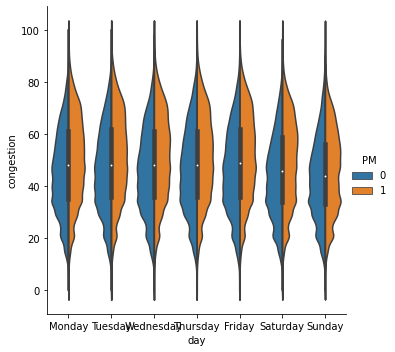

In [22]:
# plt.figure(dpi=150,figsize=(15,12))
sns.catplot(x='day',y='congestion',data=df,hue='PM',kind='violin',split=True)

## TIME SERIES VISUALIZATION

Note: A major portion of the code has been repeated in each cell. I have written a function for it and I will upload it in the upcoming versions.

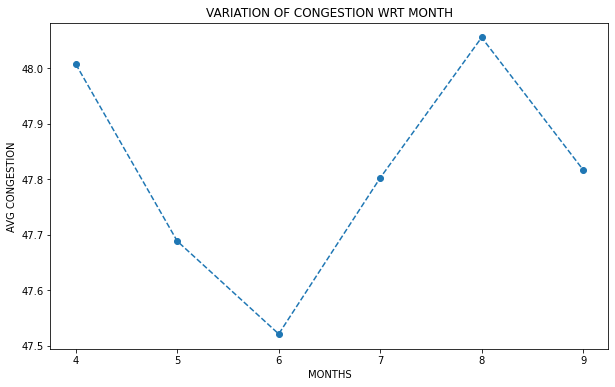

In [23]:
avg_congestion_per_month = {x:0 for x in range(4,10)}

#getting the total congestion value for a month
for i in range(len(df)):
    avg_congestion_per_month[df['month'].iloc[i]] += df['congestion'].iloc[i]

#getting the average congestion value for a month
for i in range(4,10):
    avg_congestion_per_month[i] /= len(df[df['month']==i])

# plotting the average congestion    
plt.figure(figsize=(10,6))
plt.plot([4,5,6,7,8,9],avg_congestion_per_month.values(),marker='o',linestyle='--')
plt.xlabel('MONTHS')
plt.ylabel('AVG CONGESTION')
plt.title('VARIATION OF CONGESTION WRT MONTH');

Seems like we have a low congestion value for the month of **June**

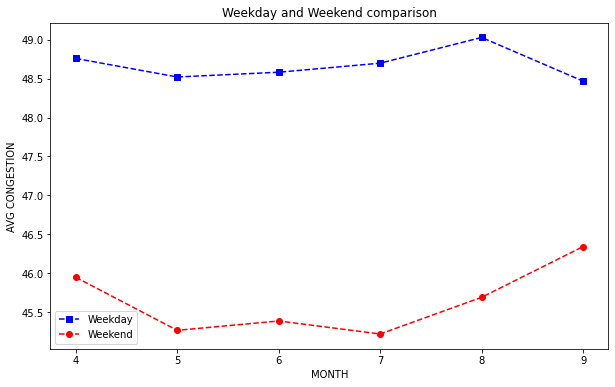

In [24]:
# avg congestion per month but this time based on part of the day
avg_congestion_per_month_wd = {x:0 for x in range(4,10)}
avg_congestion_per_month_we = {x:0 for x in range(4,10)}

# avg congestion for weekend and weekday
for i in range(len(df)):
    if df['weekday'].iloc[i] == 1:
        avg_congestion_per_month_wd[df['month'].iloc[i]] += df['congestion'].iloc[i]
    else:
        avg_congestion_per_month_we[df['month'].iloc[i]] += df['congestion'].iloc[i]

for i in range(4,10):
    avg_congestion_per_month_wd[i] /= len(df[(df['month']==i)&(df['weekday']==1)])
    avg_congestion_per_month_we[i] /= len(df[(df['month']==i)&(df['weekday']==0)])


#plotting it out
plt.figure(figsize=(10,6))
plt.plot([4,5,6,7,8,9],avg_congestion_per_month_wd.values(),label='Weekday',marker='s',linestyle='--',c='b')
plt.xlabel('MONTH')
plt.ylabel('AVG CONGESTION')

plt.plot([4,5,6,7,8,9],avg_congestion_per_month_we.values(),label='Weekend',marker='o',linestyle='--',c='r')

plt.title("Weekday and Weekend comparison")
plt.legend(loc='best');

There is a considerable difference in the avg congestion for weekday and weekend. It's good that I had encoded the value of 1 for Weekday

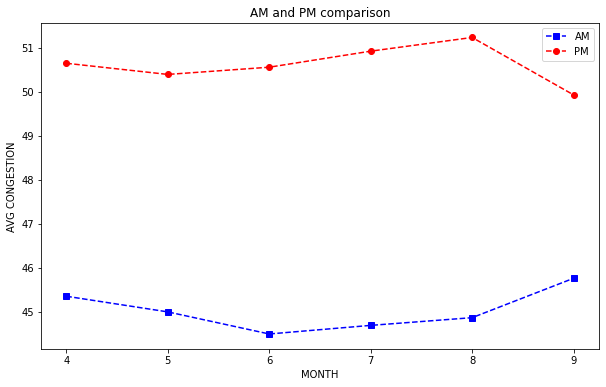

In [25]:
# we have got it for month and weekday and weekend. Now let's do it for part of the day
avg_congestion_per_month_am = {x:0 for x in range(4,10)}
avg_congestion_per_month_pm = {x:0 for x in range(4,10)}

for i in range(len(df)):
    if df['PM'].iloc[i] == 1:
        avg_congestion_per_month_pm[df['month'].iloc[i]] += df['congestion'].iloc[i]
    else:
        avg_congestion_per_month_am[df['month'].iloc[i]] += df['congestion'].iloc[i]

for i in range(4,10):
    avg_congestion_per_month_pm[i] /= len(df[(df['month']==i)&(df['PM']==1)])
    avg_congestion_per_month_am[i] /= len(df[(df['month']==i)&(df['PM']==0)])


#plotting it out
plt.figure(figsize=(10,6))
plt.plot([4,5,6,7,8,9],avg_congestion_per_month_am.values(),label='AM',marker='s',linestyle='--',c='b')
plt.plot([4,5,6,7,8,9],avg_congestion_per_month_pm.values(),label='PM',marker='o',linestyle='--',c='r')

plt.xlabel('MONTH')
plt.ylabel('AVG CONGESTION')

plt.title("AM and PM comparison")
plt.legend(loc='best');

Again there is a considerable difference. These features are important when it comes to model training and it's a good thing that I had encoded the value of 1 for PM.

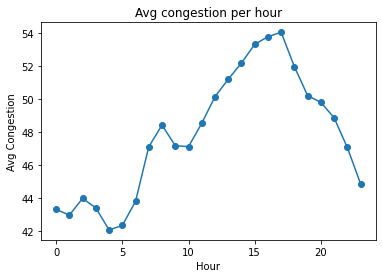

In [26]:
avg_congestion_per_hour = {x:0 for x in range(24)}
for i in range(len(df)):
    avg_congestion_per_hour[df['hour'].iloc[i]] += df['congestion'].iloc[i]
for i in range(24):
    avg_congestion_per_hour[i] /= len(df[df['hour']==i])

plt.plot([x for x in range(24)],avg_congestion_per_hour.values(),marker='o')
plt.xlabel('Hour')
plt.ylabel('Avg Congestion')
plt.title('Avg congestion per hour');

In [27]:
# let's try to find the avg of congestion for all possible combinations of the 'x' and 'y' and co-ordinates

comb_x_y = {x:[] for x in range(4,10)}
cols = []

for i in range(6): # for months -> 4,5,6,7,8,9
    for j in range(3): # for x-coordinates -> 0,1,2
        for k in range(4): # for y-coordinates -> 0,1,2,3
            req_sum = df[(df['x']==j)&(df['y']==k)&(df['month']==i+4)]['congestion'].sum() #congestion sum for x and y
            req_mean = req_sum/len(df[(df['x']==j)&(df['y']==k)&(df['month']==i+4)]) # congestion mean
            comb_x_y[i+4].append(req_mean)
            if i==0:
                cols.append('x_'+str(j)+'_y_'+str(k))

#creating a dataframe from the mean congestion values obtained so that we can visualize the data
comb_x_y_df = pd.DataFrame(comb_x_y).transpose() 
comb_x_y_df.columns = cols
comb_x_y_df

,x_0_y_0,x_0_y_1,x_0_y_2,x_0_y_3,x_1_y_0,x_1_y_1,x_1_y_2,x_1_y_3,x_2_y_0,x_2_y_1,x_2_y_2,x_2_y_3
4,45.668216,50.429949,49.331204,38.078996,46.299411,52.990125,55.439978,49.097661,62.111059,41.011327,48.861989,45.255266
5,45.366457,49.811263,48.699191,37.797512,46.062575,52.112635,55.351169,48.849296,61.454024,40.437331,49.230103,44.936826
6,45.340600,49.130798,48.391002,37.496753,45.776361,51.265422,55.186456,48.890461,61.454777,40.021452,49.507653,45.255025
7,46.077912,49.360812,49.135375,38.433154,46.502094,51.230597,55.216390,48.979886,61.760431,39.831427,49.918573,45.028264
8,45.741780,49.845475,49.313462,38.504299,46.859955,53.521719,56.286124,48.923756,61.758258,39.913179,49.449548,45.046078
9,45.331098,49.071959,48.290350,38.784004,46.298691,53.357519,56.230683,48.755109,61.469109,40.216774,49.024485,44.834211


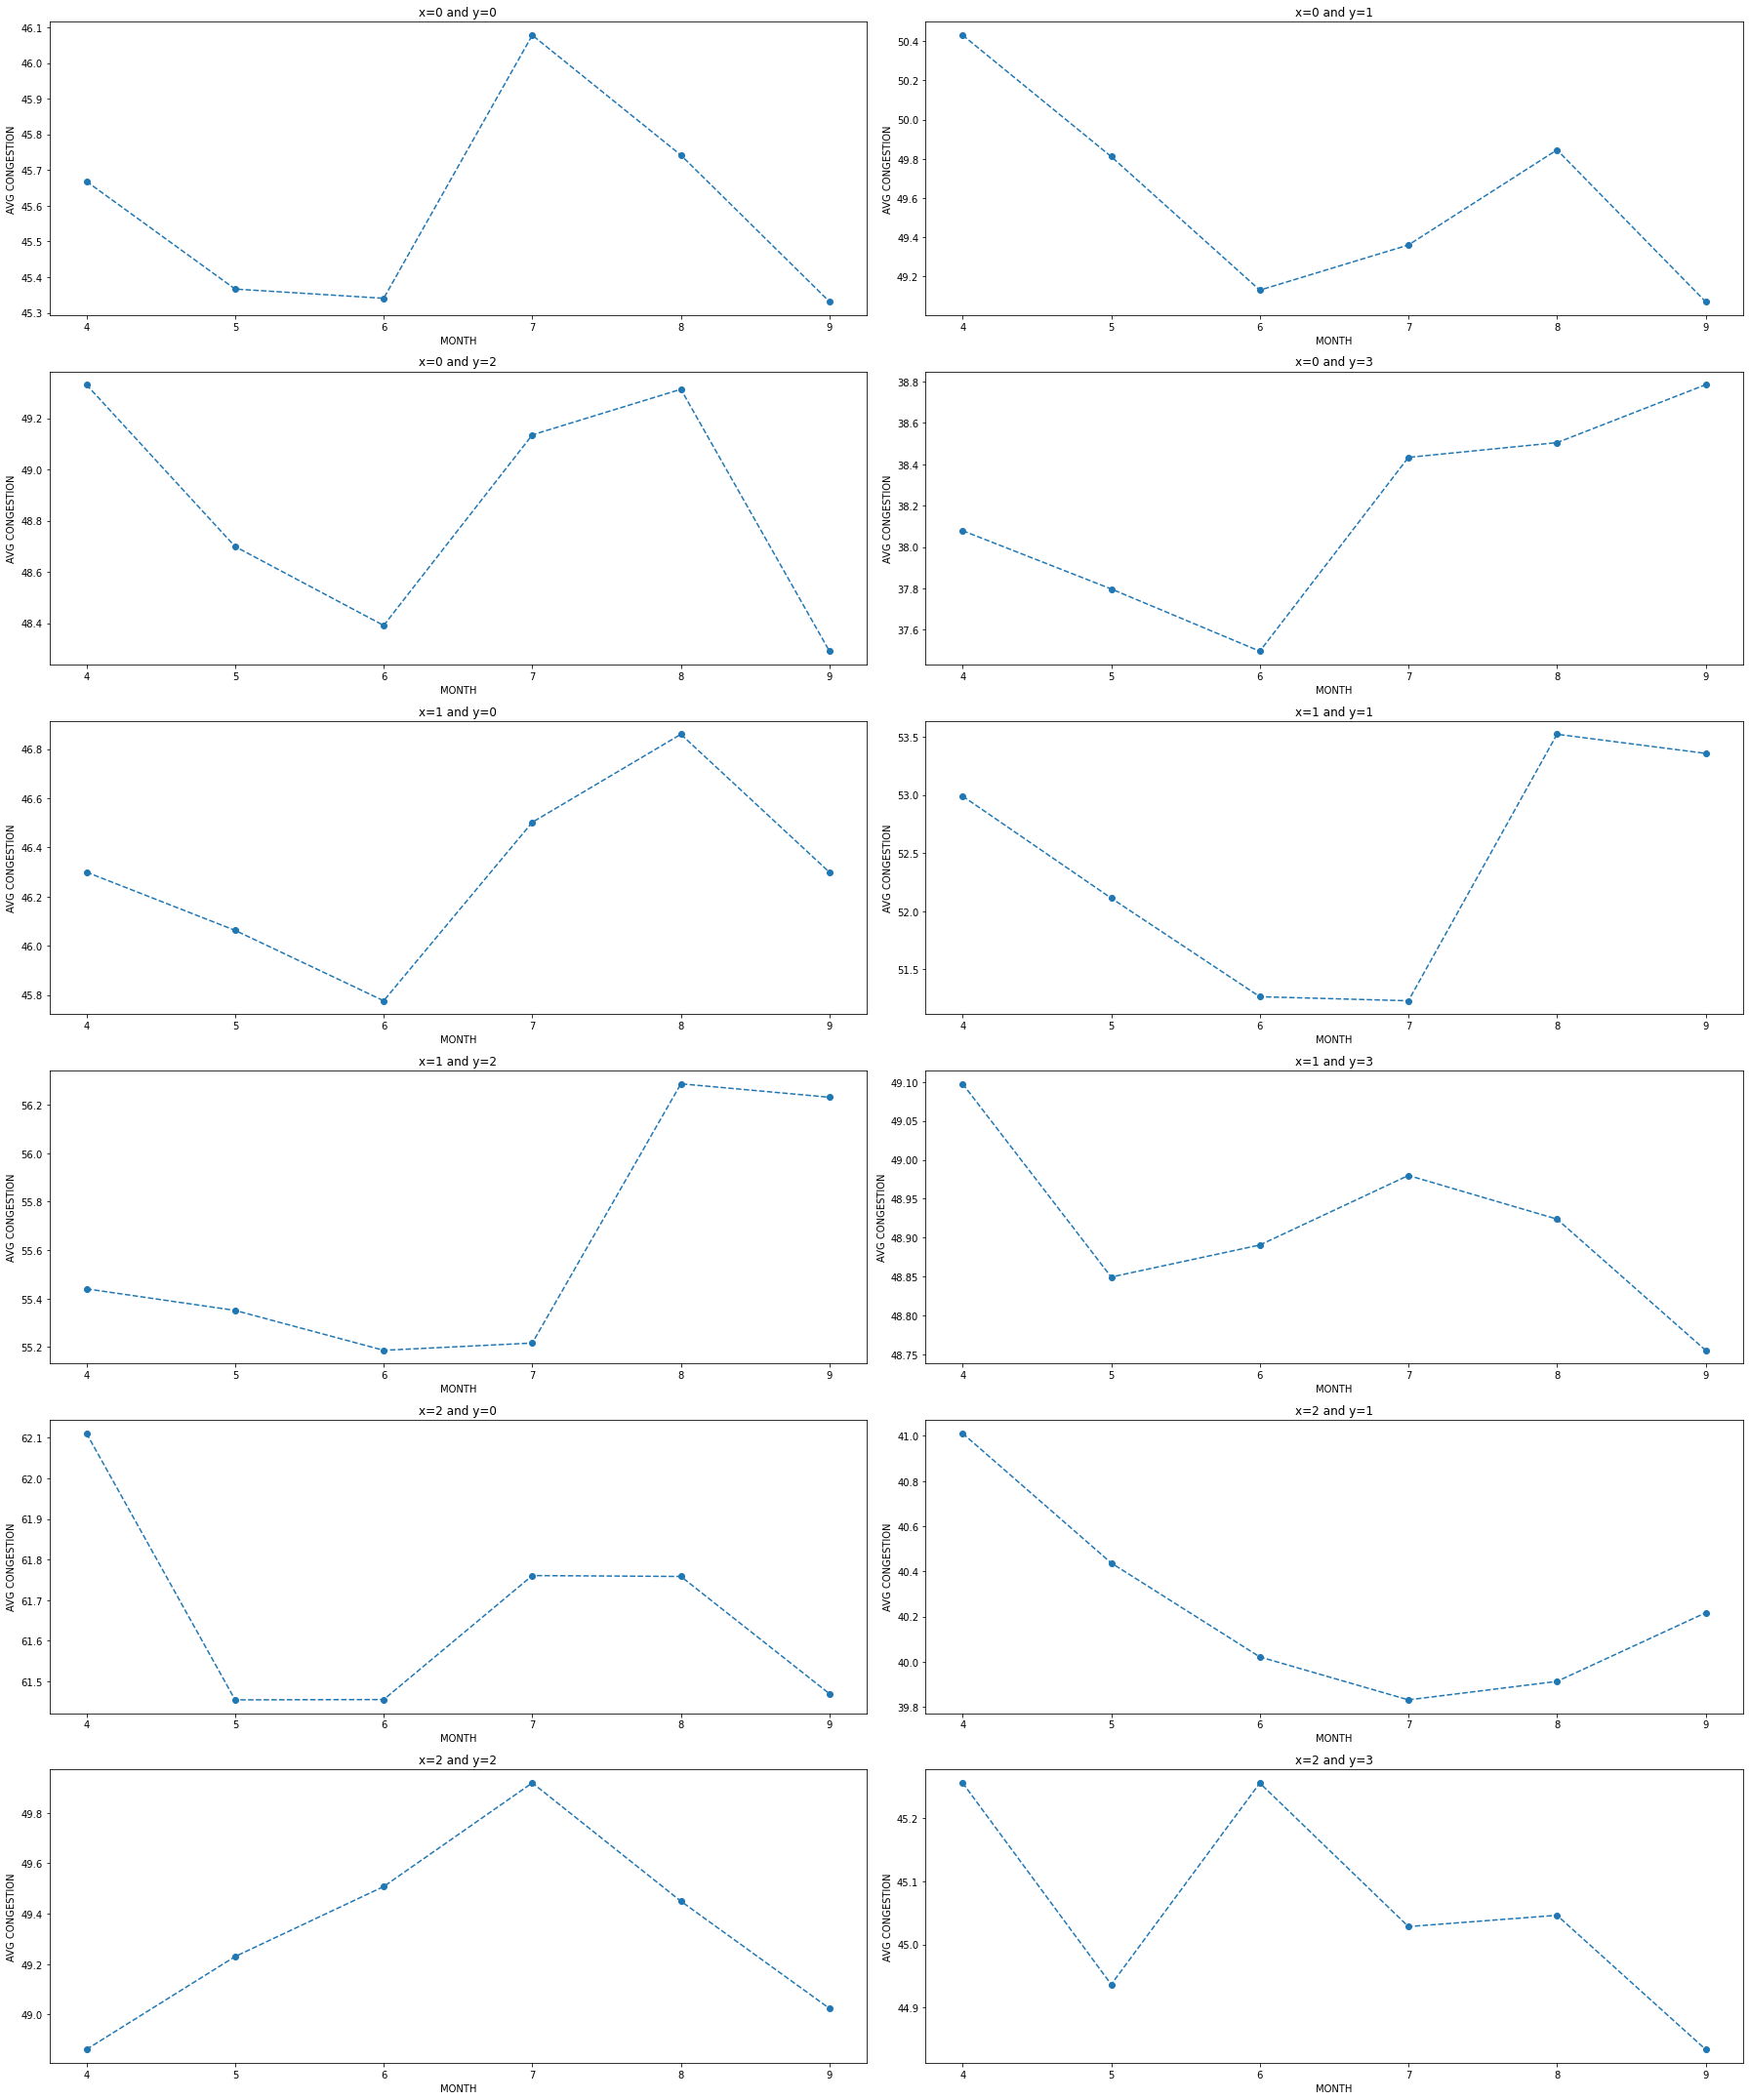

In [28]:
# plotting the avg congestion data obtained above
col = 0

fig,ax_arr = plt.subplots(nrows=6,ncols=2,figsize=(25,30))
for i in range(6):
    for j in range(2):
        c = comb_x_y_df.columns[col]
        x,y = c[2],c[6]
        ax_arr[i][j].plot(range(4,10),comb_x_y_df[c],marker='o',linestyle='--')
        ax_arr[i][j].set_xlabel('MONTH')
        ax_arr[i][j].set_ylabel('AVG CONGESTION')
        ax_arr[i][j].set_title(f'x={x} and y={y}')
        col+=1
plt.tight_layout()

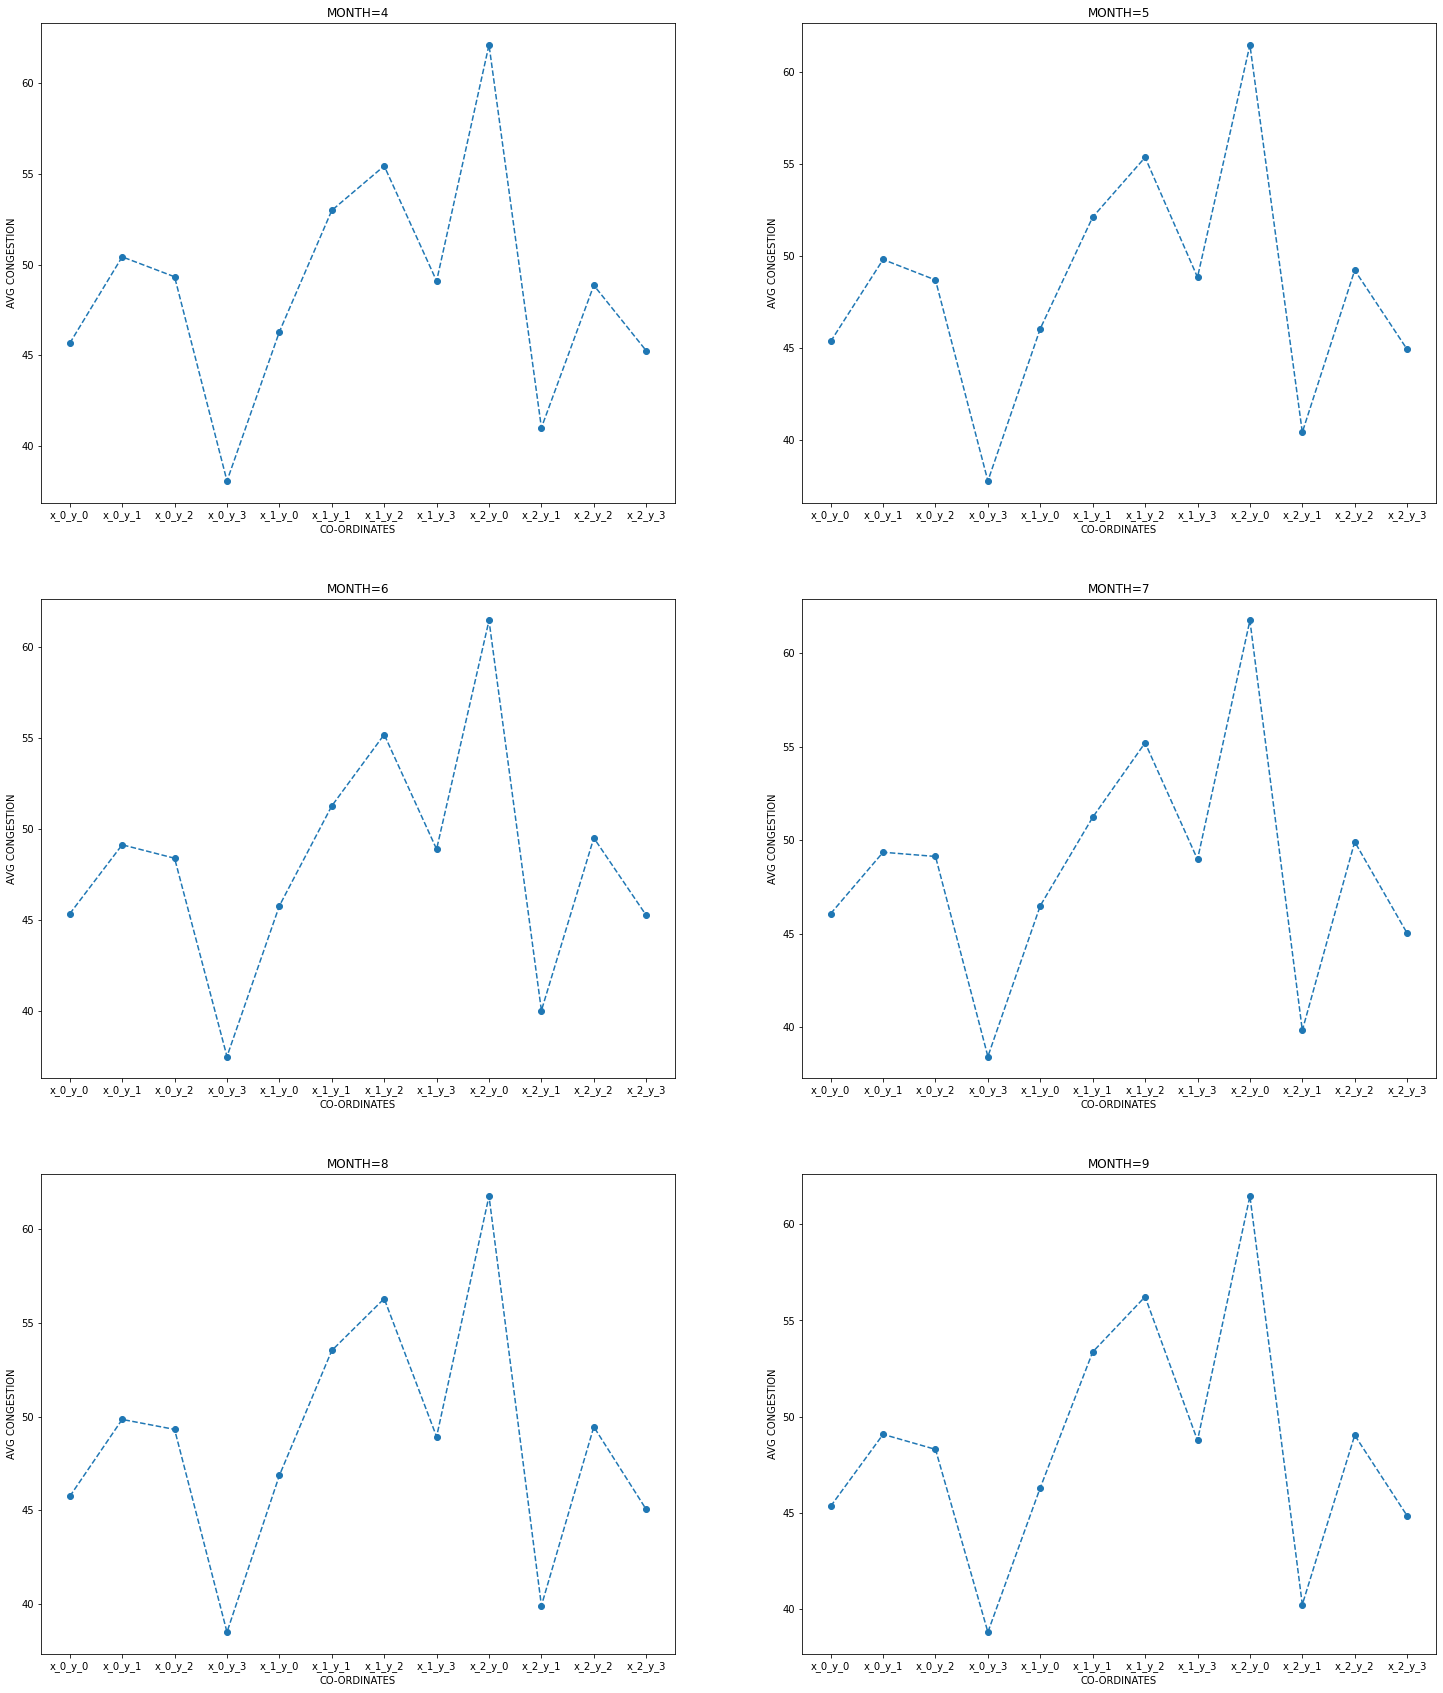

In [29]:
# comb_x_y_df = comb_x_y_df.transpose()
fig,ax_arr = plt.subplots(nrows=3,ncols=2,figsize=(25,30))
col = 4
for i in range(3):
    for j in range(2):
        ax_arr[i][j].plot(range(0,12),comb_x_y_df.transpose()[col],marker='o',linestyle='--')
        ax_arr[i][j].set_xlabel('CO-ORDINATES')
        ax_arr[i][j].set_ylabel('AVG CONGESTION')
        ax_arr[i][j].set_title('MONTH='+str(col))
        ax_arr[i][j].set_xticks(range(0,12))
        ax_arr[i][j].set_xticklabels(list(comb_x_y_df.columns))
        col+=1
        
# plt.plot(range(0,12),comb_x_y_df.transpose()[4])

In [30]:
# hour vs avg congestion with weekday as hue
week_dict = {'Monday':[],'Tuesday':[],
             'Wednesday':[],'Thursday':[],
             'Friday':[],'Saturday':[],
             'Sunday':[]}
for i in week_dict.keys():
    for j in range(24):
        req_sum = df[(df['day']==i)&(df['hour']==j)]['congestion'].sum()
        req_mean = req_sum/len(df[(df['day']==i)&(df['hour']==j)])
        week_dict[i].append(req_mean)
week_avg_cong_df = pd.DataFrame(data=week_dict)
week_avg_cong_df

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,42.148908,42.773964,43.328008,44.100000,43.318738,43.341617,44.296647
1,42.318519,42.641815,43.151677,43.849310,43.292899,42.326233,43.300000
2,44.332194,43.980276,44.419527,44.559840,43.863511,43.131953,43.660552
3,44.301425,43.841223,43.198028,44.041580,43.195005,42.145562,43.145365
4,41.996011,41.884813,41.311385,42.511243,41.851085,41.942012,43.054241
5,41.984046,41.743787,41.762872,42.581460,42.354438,42.667061,43.353452
6,44.602279,45.321105,45.163636,45.045547,45.442801,40.016765,41.140828
7,48.827920,50.386391,49.844181,49.530881,49.661736,41.012229,40.777712
8,49.826781,51.590335,50.909270,50.954915,51.073767,43.094477,41.688363
9,47.223172,48.829171,48.339645,49.063825,48.910848,45.438264,42.567258


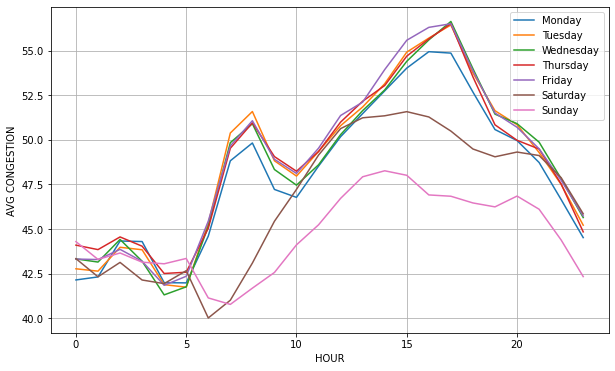

In [31]:
plt.figure(figsize=(10,6))
plt.grid()
for i in week_dict.keys():
    plt.plot(range(0,24),week_avg_cong_df[i],label=i)
    plt.xlabel('HOUR')
    plt.ylabel('AVG CONGESTION')
    plt.legend();

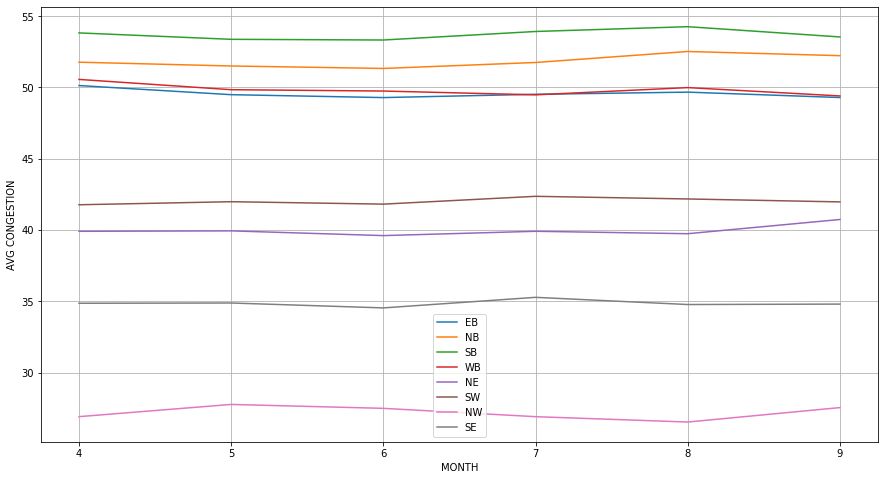

In [32]:
direction_dict = {x:[] for x in range(4,10)}
directions = list(df['direction'].unique())

for d in range(4,10):
    for direction in directions:
        req_sum = df[(df['month']==d)&(df['direction']==direction)]['congestion'].sum()
        req_mean = req_sum/len(df[(df['month']==d)&(df['direction']==direction)])
        direction_dict[d].append(req_mean)

direction_dict_df = pd.DataFrame(direction_dict).transpose() 
direction_dict_df.columns = directions

plt.figure(figsize=(15,8))
plt.grid()
for direction in directions:
    plt.plot(range(4,10),direction_dict_df[direction],label=direction)
    plt.xlabel("MONTH")
    plt.ylabel("AVG CONGESTION")
    plt.legend();

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


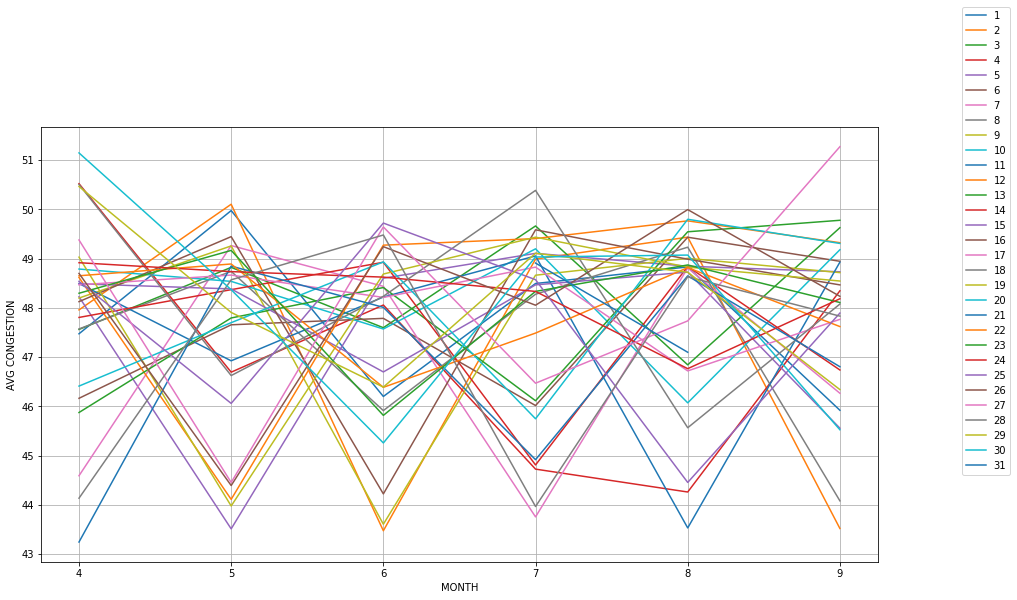

In [33]:
days_dict = {x:[] for x in range(4,10)}

for d in range(4,10):
    for date in range(1,32):
        req_sum = df[(df['month']==d)&(df['date']==date)]['congestion'].sum()
        req_mean = req_sum/len(df[(df['month']==d)&(df['date']==date)])
        days_dict[d].append(req_mean)

days_dict_df = pd.DataFrame(days_dict).transpose() 
days_dict_df.columns = list(x for x in range(1,32))

plt.figure(figsize=(15,8))
plt.grid()
for d in range(1,32):
    plt.plot(range(4,10),days_dict_df[d],label=d)
    plt.xlabel("MONTH")
    plt.ylabel("AVG CONGESTION")
    plt.legend(loc=(1.1,0.2));

In [34]:
df['direction'].nunique()

8

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_

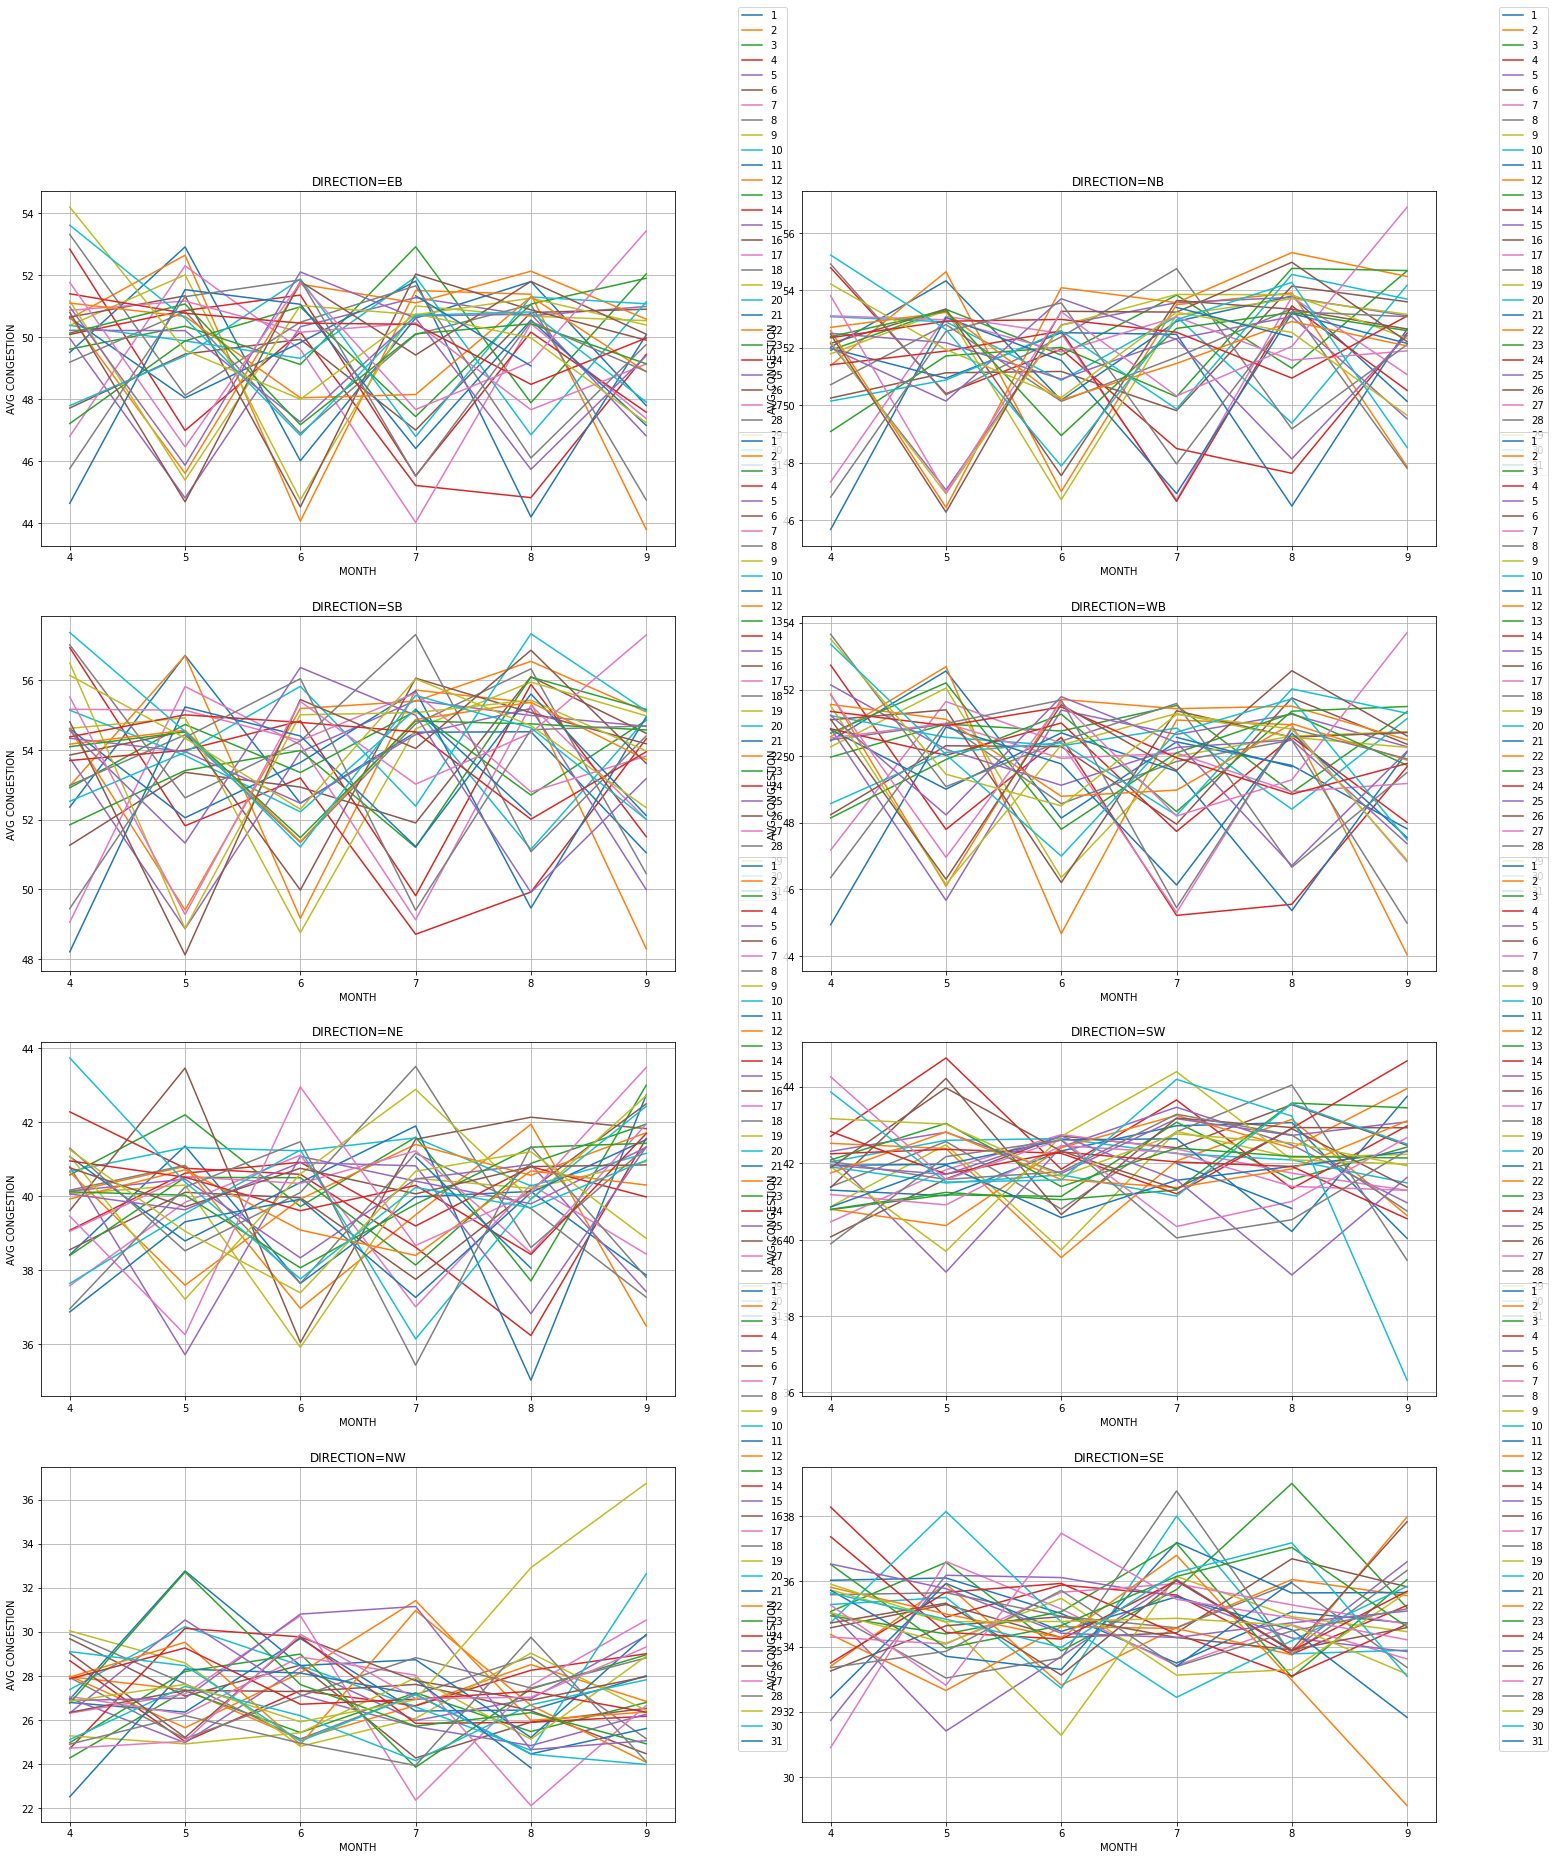

In [35]:
fig,ax_arr = plt.subplots(nrows=4,ncols=2,figsize=(25,30))
direction = 0
for i in range(4):
    for j in range(2):
        days_dict = {x:[] for x in range(4,10)}

        for d in range(4,10):
            for date in range(1,32):
                req_sum = df[(df['month']==d)&(df['date']==date)&(df['direction']==directions[direction])]['congestion'].sum()
                req_mean = req_sum/len(df[(df['month']==d)&(df['date']==date)&(df['direction']==directions[direction])])
                days_dict[d].append(req_mean)

        days_dict_df = pd.DataFrame(days_dict).transpose() 
        days_dict_df.columns = list(x for x in range(1,32))

            # plt.figure(figsize=(15,8))
        ax_arr[i][j].grid()
        for d in range(1,32):
                ax_arr[i][j].plot(range(4,10),days_dict_df[d],label=d)
                ax_arr[i][j].set_xlabel("MONTH")
                ax_arr[i][j].set_ylabel("AVG CONGESTION")
                ax_arr[i][j].set_title(f"DIRECTION={directions[direction]}")
                ax_arr[i][j].legend(loc=(1.1,0.2));
        direction+=1

## Data Preprocessing

In [36]:
df

,x,y,direction,congestion,date,year,month,hour,minute,weekday,day,PM
row_id,,,,,,,,,,,,
0,0,0,EB,70,1,1991,4,0,0,1,Monday,0
1,0,0,NB,49,1,1991,4,0,0,1,Monday,0
2,0,0,SB,24,1,1991,4,0,0,1,Monday,0
3,0,1,EB,18,1,1991,4,0,0,1,Monday,0
4,0,1,NB,60,1,1991,4,0,0,1,Monday,0
...,...,...,...,...,...,...,...,...,...,...,...,...
848830,2,3,NB,54,30,1991,9,11,40,1,Monday,0
848831,2,3,NE,28,30,1991,9,11,40,1,Monday,0
848832,2,3,SB,68,30,1991,9,11,40,1,Monday,0


In [37]:
# let's drop the year,month and date column as they are unnecessary.
df.drop(['year','month','date'],axis=1,inplace=True)
test.drop(['year','month','date'],axis=1,inplace=True)

In [38]:
# get the X and y values
X = df.drop('congestion',axis=1)
y = df['congestion']

In [39]:
X['x'],X['y'] = X['x'].astype(str),X['y'].astype(str)
test['x'],test['y'] = test['x'].astype(str),test['y'].astype(str)
X['hour'] = X['hour']/23
X['minute'] = X['minute']/59
test['hour'] = test['hour']/23
test['minute'] = test['minute']/59

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X['direction'] = le.fit_transform(X['direction'])
test['direction'] = le.transform(test['direction'])
le = LabelEncoder()
X['day'] = le.fit_transform(X['day'])
test['day'] = le.transform(test['day'])

In [41]:
pd.get_dummies(X).columns.difference(pd.get_dummies(test).columns)

Index([], dtype='object')

In [42]:
X = pd.get_dummies(X)
test = pd.get_dummies(test)

In [43]:
X.shape,test.shape

((848835, 13), (2340, 13))

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Model preparation

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
def initial_run(models,X_train,y_train,cv=5):
    scores = []
    ind = []
    for model in models:
        estimator = Pipeline([
            ('poly',PolynomialFeatures(degree=2)),
            ('model',model)
        ])
        score = cross_val_score(estimator=estimator,X=X_train,y=y_train,cv=cv,scoring='neg_mean_absolute_error')
        score.sort()
        scores.append(score)
        ind.append(str(model))
    score_df = pd.DataFrame(data=scores,index=ind,columns=[x for x in range(1,cv+1)])
    return score_df

In [47]:
models_1 = [Lasso(),Ridge(),ElasticNet()]
initial_run(models=models_1,X_train=X_train,y_train=y_train)

,1,2,3,4,5
Lasso(),-13.384401,-13.383915,-13.379112,-13.345119,-13.340585
Ridge(),-11.997246,-11.992508,-11.971245,-11.970153,-11.956928
ElasticNet(),-13.275090,-13.271761,-13.266848,-13.235819,-13.228177


In [48]:
models_2 = [DecisionTreeRegressor()]
initial_run(models=models_2,
           X_train=X_train,
           y_train=y_train)

,1,2,3,4,5
DecisionTreeRegressor(),-6.424163,-6.415811,-6.404567,-6.401672,-6.38069


In [49]:
models_3 = [RandomForestRegressor(n_estimators=80)]
initial_run(models=models_3,
           X_train=X_train,
           y_train=y_train)

,1,2,3,4,5
RandomForestRegressor(n_estimators=80),-6.428135,-6.417473,-6.407467,-6.403955,-6.383368


In [50]:
rf = RandomForestRegressor(max_features='sqrt')
rf.fit(X_train,y_train)

RandomForestRegressor(max_features='sqrt')

In [52]:
pred = rf.predict(test)

In [53]:
pred = np.round(pred,0)

In [54]:
test['congestion'] = pred

In [55]:
submission = pd.DataFrame(test['congestion'])
submission.to_csv('sub1.csv')